In [78]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp, solve_bvp
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 40
from scipy.interpolate import interp1d

In [4]:
def generate_fishing_grounds(n_grounds = 10, x_max = 100, y_max = 100):
    return np.random.rand(n_grounds, 2) * np.array([x_max, y_max])

In [5]:
def generate_ships(n_ships = 10, x_max = 100, y_max = 100):
    return np.random.rand(n_ships, 2) * np.array([x_max, y_max])

In [6]:
def generate_ships_at_harbor(h, n_ships = 10):
    """
    Returns an n_ships x 2 array of ships at the harbor h with gaussian noise
    """
    # return np.array([h + np.random.normal(0, 1, 2) for _ in range(n_ships)])
    return np.array([h for _ in range(n_ships)])

In [7]:
def calculate_ship_distance_from_grounds(ships, grounds):
    return np.linalg.norm(ships[:, np.newaxis] - grounds, axis=2)

In [8]:
def d_matrix(ships, grounds):
    # Vectorized difference calculation
    differences = grounds - ships[:, np.newaxis]
    distances = np.linalg.norm(differences, axis=2, keepdims=True)
    return differences / (distances + 1e-6)  # Adding small value to avoid division by zero

In [9]:
def ship_ground_gaussians(ships, grounds, alpha, b=1, c=0):
    distances = np.linalg.norm(ships[:, np.newaxis] - grounds, axis=2)
    return b*np.exp(-alpha * distances**2) + c

In [10]:
def calculate_ship_distance_from_ships(ships):
    return np.linalg.norm(ships[:, np.newaxis] - ships, axis=2)

In [11]:
def harbor_attraction(U, ships, h):
    diff = h - ships
    diff_norm = np.linalg.norm(diff, axis=1, keepdims=True)
    return U[:, -2, np.newaxis] * (diff / (diff_norm + 1e-6))

In [12]:
def attraction_matrix(U, G, D, F):
    F_reshaped = F.reshape(1, -1, 1)
    return U[:, :-2, None] * G[:, :, None] * D * F_reshaped

In [13]:
def calculate_F_prime(t, F, C, rate):
    C_sum = np.sum(C, axis=0)
    return -rate * F * C_sum

In [14]:
def calculate_S_matrix(A, H):
    return np.sum(A, axis=1).reshape(-1, 2) + H

In [15]:
def calculate_x_prime(U, S):

    # Reshape U[:,-2] to have an extra dimension
    U_reshaped = U[:,-1].reshape(-1, 1)

    return U_reshaped * S

Take orthogonal unit vector to s_i, namely r_i

inner product that with p_i, take abs value

find minimum of that <r_i, p_i>

Penalize ||u_i,j(t-1) - u_i,j(t)||

so minimize over u_ij for all i, j <r_i, p_i> + ||u_i,j(t-1) - u_i,j(t)||

In [16]:
# LIKELY WRONG

def Dxs_matrix(x, grounds, ships, G, U, F, distances, differences, alpha, h):
    F_reshaped = F.reshape(1, -1, 1)
    
    # This will have shape (N, K, 1)
    outer_scalar = (U[:, :-2, None] * G[:, :, None] * F_reshaped) / (distances + 1e-6)
    
    # Calculate the inner scalar term, reshaping it to (N, K, 1, 1) to broadcast with the outer product
    inner_scalar = (alpha + 1 / (distances[..., 0]**2 + 1e-6)).reshape(*distances.shape[:2], 1, 1)
    
    # Compute the outer products
    outer_products = differences[..., np.newaxis] * differences[..., np.newaxis, :]
    
    # Identity matrix needs to be (1, 1, 2, 2) to broadcast correctly
    I_2 = np.eye(2).reshape((1, 1, 2, 2))

    # print((inner_scalar * outer_products - I_2).shape)
    
    # The term_inside_summation should have shape (N, K, 2, 2)
    term_inside_summation = outer_scalar[..., np.newaxis] * (inner_scalar * outer_products - I_2)
    
    # Sum over the second axis, corresponding to summing over 'j' (the grounds)
    # This will result in shape (N, 2, 2)
    DxS = np.sum(term_inside_summation, axis=1)

    diff = h - ships
    diff_norm = np.linalg.norm(diff, axis=1, keepdims=True) + 1e-6
    
    u_ratio = U[:, -2] / diff_norm.squeeze()

    h_outer_products = diff[..., np.newaxis] * diff[..., np.newaxis, :]

    h_inner = np.sum(diff**2, axis=1)

    h_outer_products /= h_inner[:, np.newaxis, np.newaxis] + 1e-6


    I_2 = np.eye(2).reshape((1, 2, 2))
    
    return DxS + ((h_outer_products - I_2) * u_ratio[:, np.newaxis, np.newaxis])


In [17]:
def calculate_p_f_prime(t, pf, C, rate):
    C_sum = np.sum(C, axis=0)
    return rate * pf * C_sum

In [18]:
def calculate_p_prime(p, pf, S, U, Dxs, ship_differences, differences, distances, rate, sigma, beta):
    

    # Shape: (N, 2, 2), the outer product of S
    S_outer = S[:, :, np.newaxis] * S[:, np.newaxis, :]

    # Shape: (N, K, 2), the inner product of S with the differences
    S_inner = (np.linalg.norm(S, axis=1) + 1e-6)**2

    # Shape: (N, 2, 2)
    S_outer /= (S_inner[:, np.newaxis, np.newaxis] + 1e-6)
    # print(S_outer.shape)

    # Shape: (N, 2, 2)
    U_scalar = U[:, -1][:, np.newaxis, np.newaxis]

    # Shape: (N, 2, 2)
    I_2 = np.eye(2).reshape((1, 2, 2))

    # Shape: (N, 2, 2)
    first_term = U_scalar * (I_2 - S_outer)

    # Shape: (N, 2, 2)
    dxs = (Dxs / (np.linalg.norm(S, axis=1)[:, np.newaxis, np.newaxis] + 1e-6))

    # Shape: (N, 2, 1)
    second_term = dxs @ p[:, :, np.newaxis]
# 
    # print(first_term.shape, second_term.shape)

    # Shape: (N, 2, 1)
    combined = np.matmul(first_term, second_term)

    # Shape: (N, N, 2)
    term_inside_summation = ship_differences / (np.linalg.norm(ship_differences, axis=1)**2 + 1e-6)**2

    # Shape: (N, 2)
    distance_sum = np.sum(term_inside_summation, axis=1)

    # Shape: (N, K, 2)
    inner_sum = pf[:,np.newaxis] * np.exp(-sigma * distances**2) * differences

    # Shape: (N, 2)
    sum_term = np.sum(inner_sum, axis=1) * 2*sigma*rate

    return (4 * beta * distance_sum) - sum_term - combined.squeeze()

    

In [110]:
# OUTDATED
def ode(t, y, params):
    alpha, sigma, beta, rate, U, grounds, h, x_size, F_size, p_size, x_shape, p_shape = params
    b = 1
    x = y[:x_size].reshape(x_shape)  # reshape x back to its original shape
    F = y[x_size:x_size+F_size]
    p = y[x_size + F_size: x_size + F_size + p_size].reshape(p_shape)
    pf = y[x_size + F_size + p_size:]

    differences = grounds - x[:, np.newaxis]
    distances = np.linalg.norm(differences, axis=2, keepdims=True)

    ship_diffences = x[:, np.newaxis] - x
    # ship_distances = np.linalg.norm(ship_diffences, axis=2)

    # Calculate D matrix
    D = differences / (distances + 1e-6)

    # Calculate G matrix
    G = ship_ground_gaussians(x, grounds, alpha, b=b)

    # Calculate Collection matrix
    C = ship_ground_gaussians(x, grounds, sigma, b=b)

    # Calculate A matrix
    A = attraction_matrix(U, G, D, F)

    # Calculate H
    H = harbor_attraction(U, x, h)


    S = np.sum(A, axis=1).reshape(-1, 2)

    S = S + H

    S_normal = S / (np.linalg.norm(S, axis=1, keepdims=True) + 1e-6)

    F_prime = calculate_F_prime(t, F, C, rate)

    x_prime = calculate_x_prime(U, S_normal)
    # print(np.linalg.norm(x_prime, axis=1))

          
    Dxs = Dxs_matrix(x, grounds, x, G, U, F, distances, differences, alpha, h)

    p_prime = calculate_p_prime(p, pf, S, U, Dxs, ship_diffences, differences, distances, rate, sigma, beta)

    pf_prime = calculate_p_f_prime(t, pf, C, rate)

    # print(p_prime)

    # Flatten x_prime and F_prime and concatenate them into a single 1D array
    # return np.concatenate((x_prime.flatten(), F_prime.flatten(), np.ones_like(p_prime).flatten()))
    return np.concatenate((x_prime.flatten(), F_prime.flatten(), p_prime.flatten(), pf_prime.flatten()))

In [80]:
def state(t, y, params):
    alpha, sigma, beta, rate, U, grounds, h, x_size, F_size, x_shape= params
    b = 1
    x = y[:x_size].reshape(x_shape)  # reshape x back to its original shape
    F = y[x_size:x_size+F_size]

    differences = grounds - x[:, np.newaxis]
    distances = np.linalg.norm(differences, axis=2, keepdims=True)

    # ship_distances = np.linalg.norm(ship_diffences, axis=2)

    # Calculate D matrix
    D = differences / (distances + 1e-6)

    # Calculate G matrix
    G = ship_ground_gaussians(x, grounds, alpha, b=b)

    # Calculate Collection matrix
    C = ship_ground_gaussians(x, grounds, sigma, b=b)

    # Calculate A matrix
    A = attraction_matrix(U, G, D, F)

    # Calculate H
    H = harbor_attraction(U, x, h)


    S = np.sum(A, axis=1).reshape(-1, 2)

    S = S + H

    S_normal = S / (np.linalg.norm(S, axis=1, keepdims=True) + 1e-6)

    F_prime = calculate_F_prime(t, F, C, rate)

    x_prime = calculate_x_prime(U, S_normal)

    return np.concatenate((x_prime.flatten(), F_prime.flatten()))

In [84]:
def costate(t, y, params):
    x, F, alpha, sigma, beta, rate, U, grounds, h, p_size, pf_size, p_shape = params
    b = 1
    p = y[:p_size].reshape(p_shape)  # reshape x back to its original shape
    pf = y[p_size:p_size+pf_size]
    x = x.reshape(p_shape)

    differences = grounds - x[:, np.newaxis]
    distances = np.linalg.norm(differences, axis=2, keepdims=True)

    

    ship_diffences = x[:, np.newaxis] - x

    # ship_distances = np.linalg.norm(ship_diffences, axis=2)

    # Calculate D matrix
    D = differences / (distances + 1e-6)

    # Calculate G matrix
    G = ship_ground_gaussians(x, grounds, alpha, b=b)

    # Calculate Collection matrix
    C = ship_ground_gaussians(x, grounds, sigma, b=b)

    # Calculate A matrix
    A = attraction_matrix(U, G, D, F)

    # Calculate H
    H = harbor_attraction(U, x, h)


    S = np.sum(A, axis=1).reshape(-1, 2)

    # S = S + H


    Dxs = Dxs_matrix(x, grounds, x, G, U, F, distances, differences, alpha, h)

    p_prime = calculate_p_prime(p, pf, S, U, Dxs, ship_diffences, differences, distances, rate, sigma, beta)

    pf_prime = calculate_p_f_prime(t, pf, C, rate)

    return np.concatenate((p_prime.flatten(), pf_prime.flatten()))

In [117]:
def solve_state_equations(state, params, t_final, y0):
    """ Solves the state equations forward in time from t=0 to t=t_final. """
    sol_state = solve_ivp(state, [0, t_final], y0, args=(params,), dense_output=True)
    return sol_state

def solve_costate_equations(costate, state_sol, params_costate, t_final, p0, x_size, F_size):
    """ Solves the costate equations backward in time using interpolated state values. """
    # Interpolate state solution
    t_points = np.linspace(0, t_final, num=len(state_sol.t))
    state_interpolator = interp1d(t_points, state_sol.y.T, axis=0, kind='cubic', fill_value="extrapolate")

    def costate_with_interpolated_state(t, y):
        # Reverse the time for interpolation
        x, F = state_interpolator(t_final - t)[:x_size], state_interpolator(t_final - t)[x_size:x_size+F_size]
        return costate(t, y, [x, F] + params_costate[2:])

    # Solve costate from t_final to 0
    sol_costate = solve_ivp(costate_with_interpolated_state, [t_final, 0], p0, t_eval=np.linspace(t_final, 0, num=100), method='RK45')
    return sol_costate

## MOST UPDATED CODE

done


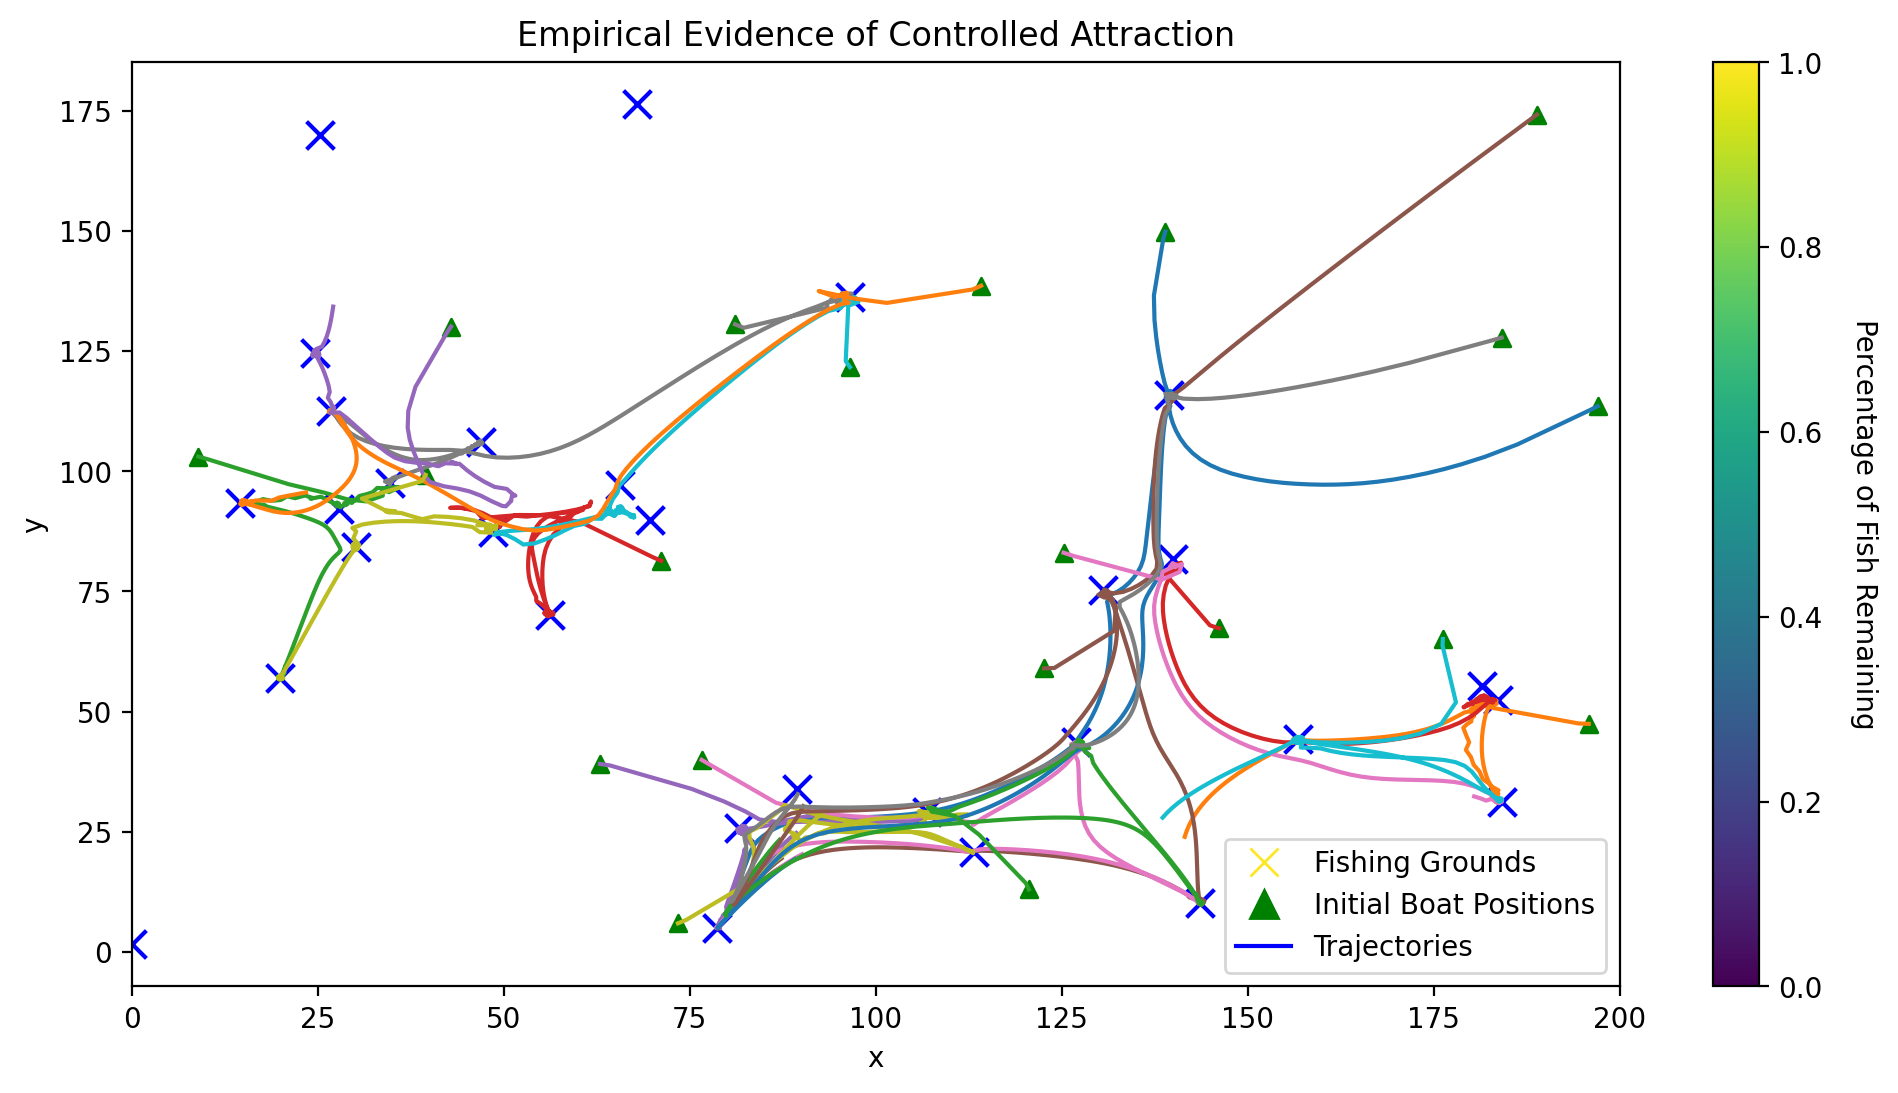

In [121]:
# Constants and initial conditions
alpha = 0.001
sigma = 0.01
beta = 1
rate = 0.01
delta = 100

x_max, y_max = 200, 200
n_ships = 20
n_grounds = 30
t_final = 500
n_steps = 50  # Define the number of steps for RK4

# Initialize scenario
# grounds = generate_fishing_grounds(n_grounds, x_max, y_max)
# ships = generate_ships(n_ships, x_max, y_max)
N = ships.shape[0]
K = grounds.shape[0]
h = np.array([x_max / 2, 0])

# U and F initialization
U = np.random.normal(1, .25, (N, K + 2))
U[:, -2] = 0
U[:, -1] = .5
F0 = 1
F = np.ones(K) * F0

# Flatten initial conditions
x = ships
x_size = np.prod(x.shape)
x_shape = x.shape
F_size = np.prod(F.shape)
p_size = x_size
p_shape = x_shape
y0 = np.concatenate((x.flatten(), F))

# Define parameters for state function
state_params = (alpha, sigma, beta, rate, U, grounds, h, x_size, F_size, x_shape)
params_costate = [x, F, alpha, sigma, beta, rate, U, grounds, h, p_size, F_size, p_shape]

# Solve state equations
sol_state = solve_state_equations(state, state_params, t_final, y0)

x = sol_state.y[:x_size].reshape((n_ships, 2, -1))

print("done")
# Prepare initial conditions for costate solution
p_init = np.zeros((n_ships, 2))
pf_init = np.full(F.shape, -delta)
p0 = np.concatenate((p_init.flatten(), pf_init))

# Solve costate equations
sol_costate = solve_costate_equations(costate, sol_state, params_costate, t_final, p0, x_size, F_size)

# Processing the results
# Reverse the solutions to match the original time order
costate_results = sol_costate.y[:, ::-1]


 
fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('none')

ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')

plt.scatter(grounds[:, 0], grounds[:, 1], c='blue', marker='x', s=100, label='Fishing Grounds')

cbar = plt.colorbar()
cbar.set_label('Percentage of Fish Remaining', rotation=270, labelpad=20)

plt.scatter(x[:, 0, 0], x[:, 1, 0], c='green', marker='^')

for i in range(x.shape[0]):
    plt.plot(x[i, 0, :], x[i, 1, :])

plt.xlabel('x')
plt.ylabel('y')
plt.title('Empirical Evidence of Controlled Attraction')

plt.xlim(0, x_max)
# plt.ylim(0, y_max)

fishing_grounds = mlines.Line2D([], [], color='#fde725', marker='x', linestyle='None', markersize=10, label='Fishing Grounds')
starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Initial Boat Positions')
trajectories = mlines.Line2D([], [], color='blue', marker='_', linestyle='-', markersize=10, label='Trajectories')

plt.legend(handles=[fishing_grounds, starting_points, trajectories], loc='lower right')

# plt.savefig('massive_resolution.png', transparent=True)
plt.show()

In [ ]:
#OUTDATED
alpha = .001
sigma = .01
beta = 1
rate = .01

x_max, y_max = 200, 200
n_ships = 20
n_grounds = 30
t_final = 500

# h is the harbor position
h = np.array([x_max / 2, 0])

grounds = generate_fishing_grounds(n_grounds, x_max, y_max)
ships = generate_ships(n_ships, x_max, y_max)
# print(ships.shape)
# ships = generate_ships_at_harbor(h, n_ships)

# put the grounds in the middle of both hemispheres

# put the ships at the harbor

# initialize U as all ones
U = np.ones((ships.shape[0], grounds.shape[0] + 2))

# initialize U with normal distribution, mean 1, std 0.1
U = np.random.normal(1, .25, (ships.shape[0], grounds.shape[0] + 2))
U = np.ones((ships.shape[0], grounds.shape[0] + 2))

# set the last column of U to 0
U[:,-2] = 0
U[:,-1] = .5

# initialize F as all ones
F = np.ones(grounds.shape[0])

# x is ship positions
x = ships



# Get the sizes of x and F before flattening
x_size = np.prod(x.shape)
x_shape = x.shape
F_size = np.prod(F.shape)

# Get the original shape of x

# Flatten x and F into a single 1D array
y0 = np.concatenate((x.flatten(), F))



state_params = (alpha, sigma, beta, rate, U, grounds, h, x_size, F_size, x_shape)

y_sol = solve_ivp(state, [0, t_final], y0, args=(state_params,), t_eval=np.linspace(0, t_final, t_final))

# Extract ship positions from the solution
x = y_sol.y[:x_size].reshape((n_ships, 2, -1))

# Extract F values from the solution
F = y_sol.y[x_size:x_size+F_size].T



# initialize p
p_init = np.full((n_ships, 2), 100)

# initialize pf, same size as F
pf_init = np.ones_like(F)
p_shape = p_init.shape
p_size = np.prod(p_init.shape)

# # Flatten p and pf into a single 1D array
# p0 = np.concatenate((p_init.flatten(), pf_init))

# costate_params = (x, F, 0, alpha, sigma, beta, rate, U, grounds, h, p_size, F_size, p_shape)

# p_sol = solve_ivp(costate, [0, t_final], p0, args=(costate_params,), t_eval=np.linspace(0, t_final, t_final))




fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('none')

ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')

plt.scatter(grounds[:, 0], grounds[:, 1], c='blue', marker='x', s=100, label='Fishing Grounds')

cbar = plt.colorbar()
cbar.set_label('Percentage of Fish Remaining', rotation=270, labelpad=20)

plt.scatter(x[:, 0, 0], x[:, 1, 0], c='green', marker='^')

for i in range(x.shape[0]):
    plt.plot(x[i, 0, :], x[i, 1, :])

plt.xlabel('x')
plt.ylabel('y')
plt.title('Empirical Evidence of Controlled Attraction')

plt.xlim(0, x_max)
# plt.ylim(0, y_max)

fishing_grounds = mlines.Line2D([], [], color='#fde725', marker='x', linestyle='None', markersize=10, label='Fishing Grounds')
starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Initial Boat Positions')
trajectories = mlines.Line2D([], [], color='blue', marker='_', linestyle='-', markersize=10, label='Trajectories')

plt.legend(handles=[fishing_grounds, starting_points, trajectories], loc='lower right')

# plt.savefig('massive_resolution.png', transparent=True)
plt.show()

In [36]:
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.set_xlim(0, 200)
# ax.set_ylim(0, 200)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_title('Boat Trajectories')
# # Plot the fishing grounds and harbor for reference
# scat = ax.scatter(grounds[:, 0], grounds[:, 1], c=F_normalized, cmap='viridis', label='Fishing Grounds', marker='x', s=100)

# # Add colorbar
# cbar = plt.colorbar(scat)
# cbar.set_label('Percentage of Fish Remaining', rotation=270, labelpad=20)
# plt.tight_layout()

# # Initialize lines for each ship, storing them in a list
# lines = [ax.plot([], [], marker='^', linestyle='-', color='green', linewidth=0.5)[0] for _ in range(ships.shape[0])]

# def init():
#     # Initialize lines
#     for line in lines:
#         line.set_data([], [])
#     return lines

# def animate(frame):
#     # Update each ship's position for the current frame
#     for i, line in enumerate(lines):
#         line.set_data(ship_positions[i, 0, frame], ship_positions[i, 1, frame])
    
#     # Update the color of the fishing grounds
#     F_current = sol.y[:, frame][x_size:x_size+F_size]
#     F_normalized_current = (F_current / np.max(F)) * 100
#     scat.set_array(F_normalized_current)
    
#     return lines

# # Create the animation
# # Create the animation
# starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Boat Positions')
# ani = FuncAnimation(fig, animate, frames=ship_positions.shape[2] - 1, init_func=init, blit=True, interval=20)

# plt.legend(handles=[fishing_grounds, starting_points], loc='upper left')
# plt.close(fig)

# # Display the animation
# HTML(ani.to_jshtml())

In [37]:
# # save the animation as gif
# ani.save('visualizations/boat_trajectories.gif', fps=30)